# Budowa modelu predykcyjnego do przewidywania zdolności kredytowej
## Wykorzystano dane ``Credit Approval``, źródło: https://archive.ics.uci.edu/dataset/27/credit+approval

# Wczytanie danych

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
file_path = "/content/drive/MyDrive/creditAproval.7z"


In [ ]:
!apt-get install -y p7zip-full


In [ ]:
!7z x "/content/drive/MyDrive/creditAproval.7z" -o/content/extracted_data


In [23]:
import os
os.listdir("/content/extracted_data")


['creditAproval']

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Wstępny przegląd danych

In [25]:
import pandas as pd

df_crx = pd.read_csv(
    "/content/extracted_data/creditAproval/crx.data",
    header=None,
    na_values='?'
)

df_crx.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
1,b,30.83,0,u,g,w,v,1.25,t,t,01,f,g,00202,0,+
2,a,58.67,4.46,u,g,q,h,3.04,t,t,06,f,g,00043,560,+
3,a,24.50,0.5,u,g,q,h,1.5,t,f,0,f,g,00280,824,+
4,b,27.83,1.54,u,g,w,v,3.75,t,t,05,t,g,00100,3,+


In [26]:
df_crx.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')

## Zamiana pierwszego rzędu w kolumny

In [27]:
df_crx.columns = df_crx.iloc[0]
df_crx = df_crx[1:].reset_index(drop=True)

display(df_crx.head())

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0,u,g,w,v,1.25,t,t,01,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,06,f,g,00043,560,+
2,a,24.50,0.5,u,g,q,h,1.5,t,f,0,f,g,00280,824,+
3,b,27.83,1.54,u,g,w,v,3.75,t,t,05,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [28]:
df_crx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A1      678 non-null    object
 1    A2     678 non-null    object
 2    A3     690 non-null    object
 3    A4     684 non-null    object
 4    A5     684 non-null    object
 5    A6     681 non-null    object
 6    A7     681 non-null    object
 7    A8     690 non-null    object
 8    A9     690 non-null    object
 9    A10    690 non-null    object
 10   A11    690 non-null    object
 11   A12    690 non-null    object
 12   A13    690 non-null    object
 13   A14    677 non-null    object
 14   A15    690 non-null    object
 15   A16    690 non-null    object
dtypes: object(16)
memory usage: 86.4+ KB


In [29]:
df_crx.shape

(690, 16)

## Sprawdzenie brakujących wartości

In [30]:
df_crx.isna().sum()

,0
0,
A1,12
A2,12
A3,0
A4,6
A5,6
A6,9
A7,9
A8,0
A9,0


## Zamiana kolumny target na wartości liczbowe

In [32]:
df_crx.columns = df_crx.columns.str.strip()
df_crx['A16'] = df_crx['A16'].replace({'+': 1, '-': 0})

print("Value counts for column 'A16' after conversion:")
display(df_crx['A16'].value_counts())

Value counts for column 'A16' after conversion:


/tmp/ipython-input-1965948333.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_crx['A16'] = df_crx['A16'].replace({'+': 1, '-': 0})


,count
A16,
0,383
1,307


In [38]:
bool_series = pd.isnull(df_crx["A1"])
missing_A1_data = df_crx[bool_series]
print(missing_A1_data)

0     A1     A2     A3 A4 A5   A6   A7     A8 A9 A10 A11 A12 A13    A14   A15  \
248  NaN  24.50  12.75  u  g    c   bb   4.75  t   t  02   f   g  00073   444   
327  NaN  40.83    3.5  u  g    i   bb    0.5  f   f   0   f   s  01160     0   
346  NaN  32.25    1.5  u  g    c    v   0.25  f   f   0   t   g  00372   122   
374  NaN  28.17  0.585  u  g   aa    v   0.04  f   f   0   f   g  00260  1004   
453  NaN  29.75  0.665  u  g    w    v   0.25  f   f   0   t   g  00300     0   
479  NaN  26.50   2.71  y  p  NaN  NaN  0.085  f   f   0   f   s  00080     0   
489  NaN  45.33      1  u  g    q    v  0.125  f   f   0   t   g  00263     0   
520  NaN  20.42    7.5  u  g    k    v    1.5  t   t  01   f   g  00160   234   
598  NaN  20.08  0.125  u  g    q    v      1  f   t  01   f   g  00240   768   
601  NaN  42.25   1.75  y  p  NaN  NaN      0  f   f   0   t   g  00150     1   
641  NaN  33.17   2.25  y  p   cc    v    3.5  f   f   0   t   g  00200   141   
673  NaN  29.50      2  y  p

In [39]:
print(f"DataFrame shape before dropping NaNs: {df_crx.shape}")

df_crx_cleaned = df_crx.dropna()

print(f"DataFrame shape after dropping NaNs: {df_crx_cleaned.shape}")
display(df_crx_cleaned.head())

DataFrame shape before dropping NaNs: (690, 16)
DataFrame shape after dropping NaNs: (653, 16)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0,u,g,w,v,1.25,t,t,01,f,g,00202,0,1
1,a,58.67,4.46,u,g,q,h,3.04,t,t,06,f,g,00043,560,1
2,a,24.50,0.5,u,g,q,h,1.5,t,f,0,f,g,00280,824,1
3,b,27.83,1.54,u,g,w,v,3.75,t,t,05,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


In [43]:
df_cleaned = df_crx_cleaned.copy()

## Pozbyto się wartości brakujących przez ich usunięcie

In [44]:
df_cleaned.isna().sum()

,0
0,
A1,0
A2,0
A3,0
A4,0
A5,0
A6,0
A7,0
A8,0
A9,0


In [45]:
df_cleaned.shape

(653, 16)

In [47]:
numerical_cols_to_convert = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A16']

for col in numerical_cols_to_convert:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print("DataFrame info after converting numerical columns:")
display(df_cleaned.info())

DataFrame info after converting numerical columns:
<class 'pandas.core.frame.DataFrame'>
Index: 653 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      653 non-null    object 
 1   A2      653 non-null    float64
 2   A3      653 non-null    float64
 3   A4      653 non-null    object 
 4   A5      653 non-null    object 
 5   A6      653 non-null    object 
 6   A7      653 non-null    object 
 7   A8      653 non-null    float64
 8   A9      653 non-null    object 
 9   A10     653 non-null    object 
 10  A11     653 non-null    int64  
 11  A12     653 non-null    object 
 12  A13     653 non-null    object 
 13  A14     653 non-null    int64  
 14  A15     653 non-null    int64  
 15  A16     653 non-null    int64  
dtypes: float64(3), int64(4), object(9)
memory usage: 86.7+ KB


None

In [52]:
target = df_cleaned[['A16']]
features = df_cleaned.drop(columns=['A16'])

Index(['A16'], dtype='object', name=0)

## Histogramy wartości numerycznych

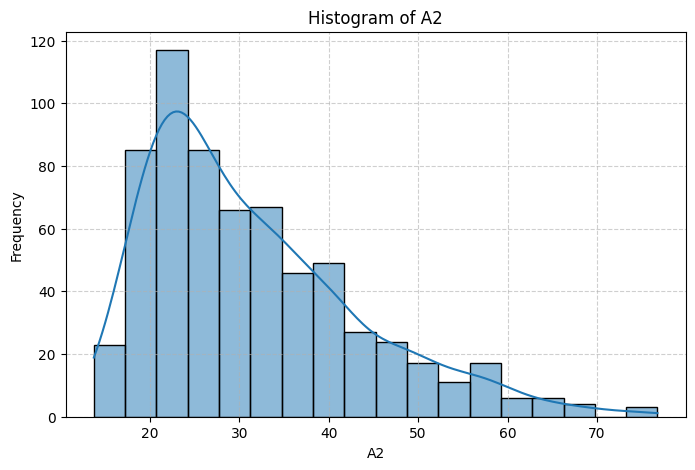

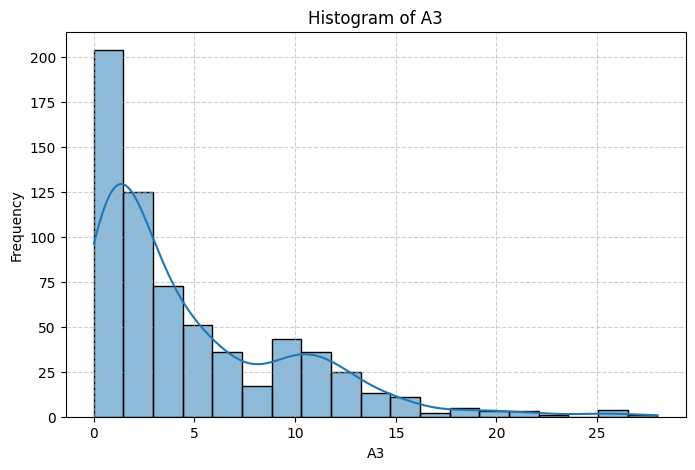

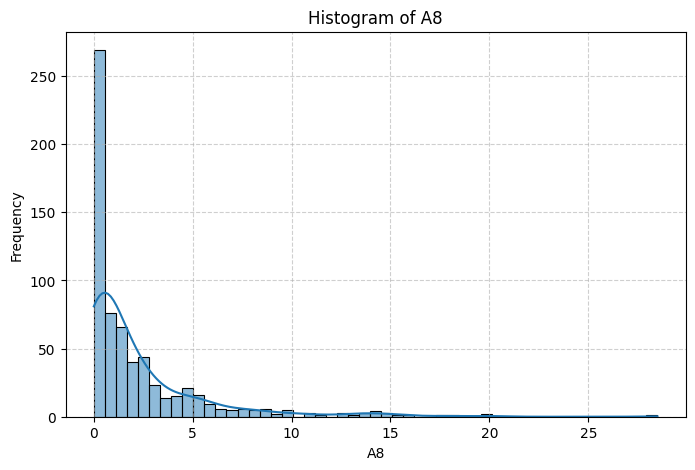

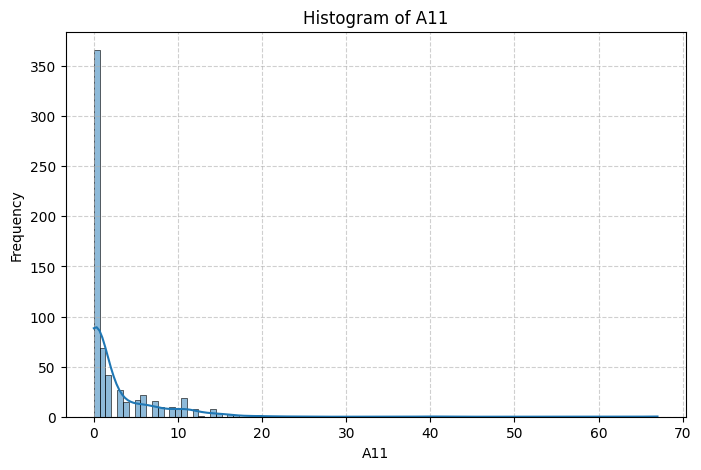

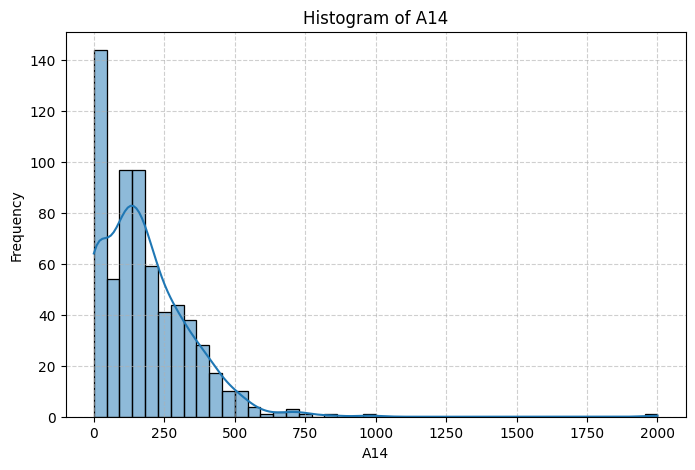

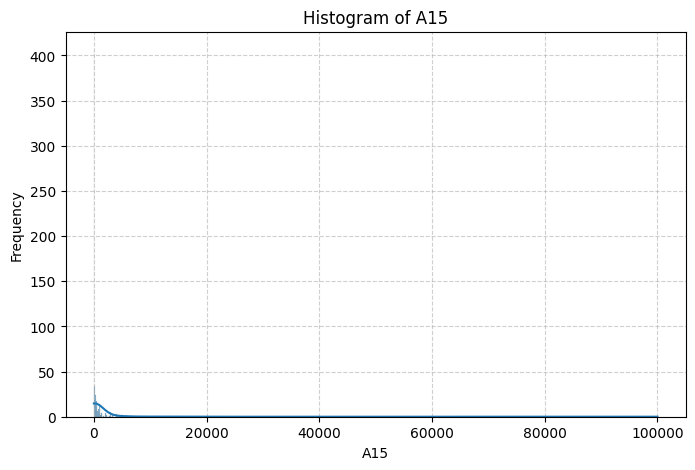

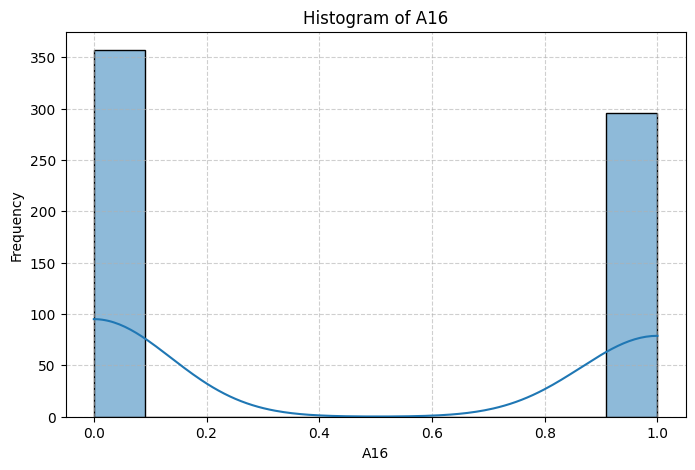

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A16']

for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [56]:
numerical_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A16']

print("Unique values count for numerical columns:")
for col in numerical_cols:
    print(f"Column '{col}': {df_cleaned[col].nunique()} unique values")

Unique values count for numerical columns:
Column 'A2': 340 unique values
Column 'A3': 213 unique values
Column 'A8': 131 unique values
Column 'A11': 23 unique values
Column 'A14': 164 unique values
Column 'A15': 229 unique values
Column 'A16': 2 unique values


## Pozbycie się wartości brakujących wypełniając je
# Numeryczne - Medianą
# Kategoryczne - Modą

In [ ]:
# Create a copy of the DataFrame
df_filled = df_crx.copy()

# Define numerical columns to convert (as identified previously)
numerical_cols_for_conversion = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A16']

# Convert potential numerical columns to numeric types, coercing errors
for col in numerical_cols_for_conversion:
    df_filled[col] = pd.to_numeric(df_filled[col], errors='coerce')

# Separate numerical and categorical columns after type conversion
numerical_cols = df_filled.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_filled.select_dtypes(include=['object']).columns.tolist()

print("Missing values BEFORE imputation:")
display(df_filled.isnull().sum())

# Impute missing numerical values with the median
for col in numerical_cols:
    if df_filled[col].isnull().any():
        df_filled[col].fillna(df_filled[col].median(), inplace=True)

# Impute missing categorical values with the mode
for col in categorical_cols:
    if df_filled[col].isnull().any():
        df_filled[col].fillna(df_filled[col].mode()[0], inplace=True)

print("\nMissing values AFTER imputation (in df_filled):")
display(df_filled.isnull().sum())

print("\nDataFrame info for df_filled after imputation:")
display(df_filled.info())

display(df_filled.head())

In [70]:
df_filled.shape

(690, 16)

## Statystyki wartości numerycznych

In [71]:
print("Descriptive statistics for numerical columns in df_filled:")

numerical_cols_filled = df_filled.select_dtypes(include=['number']).columns

for col in numerical_cols_filled:
    print(f"\n--- Column: {col} ---")
    print(f"Mean: {df_filled[col].mean():.2f}")
    print(f"Median: {df_filled[col].median():.2f}")
    print(f"Standard Deviation: {df_filled[col].std():.2f}")
    print(f"Min: {df_filled[col].min():.2f}")
    print(f"Max: {df_filled[col].max():.2f}")

print("\n--- Comprehensive Summary using .describe() ---")
display(df_filled[numerical_cols_filled].describe())

Descriptive statistics for numerical columns in df_filled:

--- Column: A2 ---
Mean: 31.51
Median: 28.46
Standard Deviation: 11.86
Min: 13.75
Max: 80.25

--- Column: A3 ---
Mean: 4.76
Median: 2.75
Standard Deviation: 4.98
Min: 0.00
Max: 28.00

--- Column: A8 ---
Mean: 2.22
Median: 1.00
Standard Deviation: 3.35
Min: 0.00
Max: 28.50

--- Column: A11 ---
Mean: 2.40
Median: 0.00
Standard Deviation: 4.86
Min: 0.00
Max: 67.00

--- Column: A14 ---
Mean: 183.56
Median: 160.00
Standard Deviation: 172.19
Min: 0.00
Max: 2000.00

--- Column: A15 ---
Mean: 1017.39
Median: 5.00
Standard Deviation: 5210.10
Min: 0.00
Max: 100000.00

--- Column: A16 ---
Mean: 0.44
Median: 0.00
Standard Deviation: 0.50
Min: 0.00
Max: 1.00

--- Comprehensive Summary using .describe() ---


,A2,A3,A8,A11,A14,A15,A16
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000
mean,31.514116,4.758725,2.223406,2.40000,183.562319,1017.385507,0.444928
std,11.860245,4.978163,3.346513,4.86294,172.190278,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,22.670000,1.000000,0.165000,0.00000,80.000000,0.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000,0.000000
75%,37.707500,7.207500,2.625000,3.00000,272.000000,395.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000,1.000000


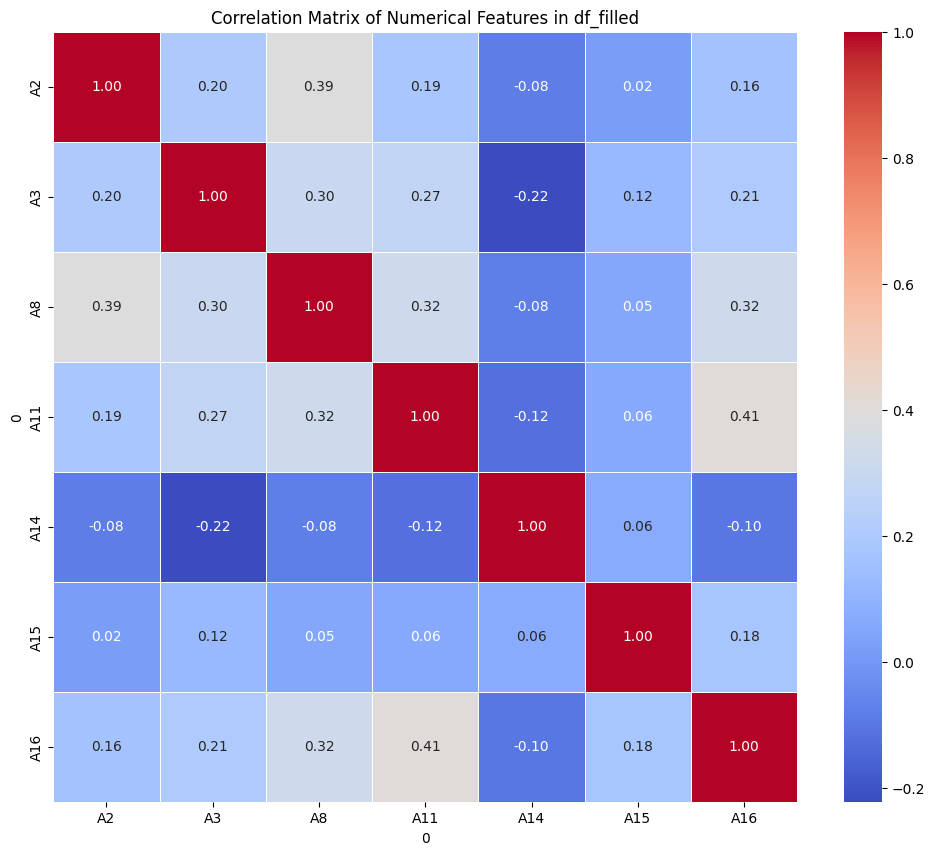

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df_filled = df_filled.select_dtypes(include=['number'])

correlation_matrix = numerical_df_filled.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features in df_filled')
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

X = df_filled.drop(columns=['A16'])
y = df_filled['A16']

categorical_cols_X = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns identified in X: {categorical_cols_X}")

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


encoded_features = encoder.fit_transform(X[categorical_cols_X])


encoded_feature_names = encoder.get_feature_names_out(categorical_cols_X)
X_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)


X_numerical = X.drop(columns=categorical_cols_X)


X_processed = pd.concat([X_numerical, X_encoded], axis=1)

print(f"\nShape of X_processed after one-hot encoding: {X_processed.shape}")
display(X_processed.head())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)



X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

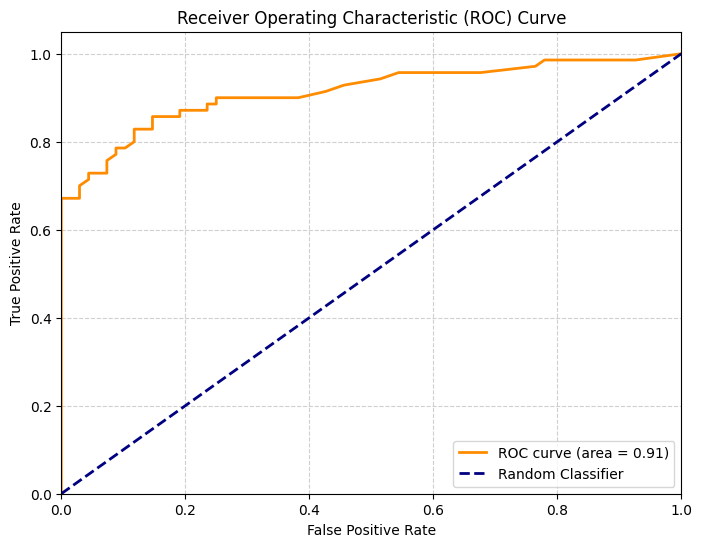

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test,y_pred)
print(f"Roc auc: {roc_auc:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Roc auc: 0.8483
Accuracy: 0.8478
Precision: 0.8769
Recall: 0.8143
F1-Score: 0.8444

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        68
           1       0.88      0.81      0.84        70

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138



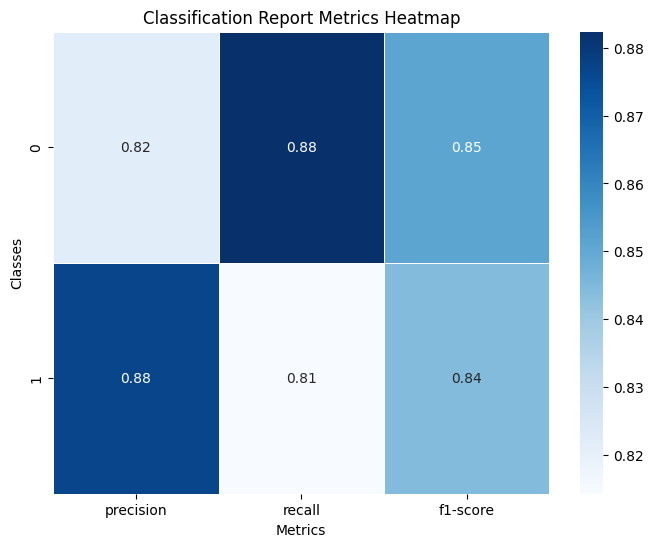

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report_dict).transpose()

df_report_filtered = df_report.loc[['0', '1'], ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(8, 6))
sns.heatmap(df_report_filtered, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Classification Report Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [66]:
from sklearn.model_selection import cross_val_score, KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_classifier, X_processed, y, cv=kf, scoring='accuracy')

average_accuracy = cv_scores.mean()

print(f"Average Accuracy across {num_folds} Folds: {average_accuracy:.4f}")

Average Accuracy across 5 Folds: 0.8768


In [74]:
df_filled.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


Numeric features: ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
Categorical features: ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']


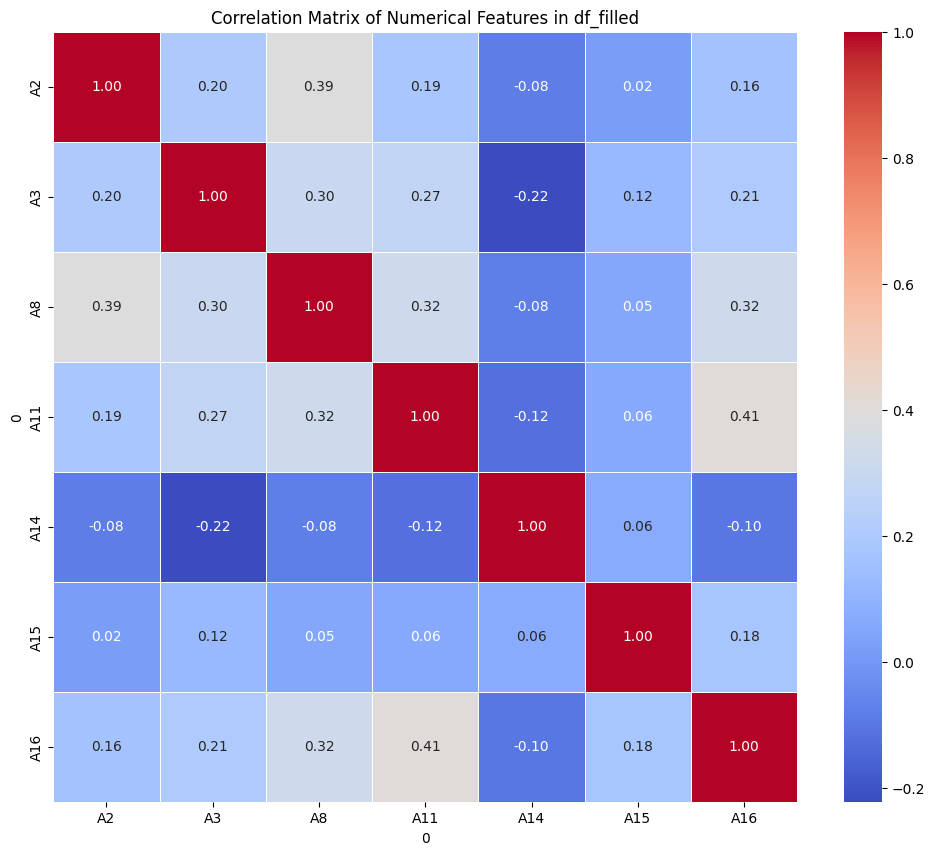

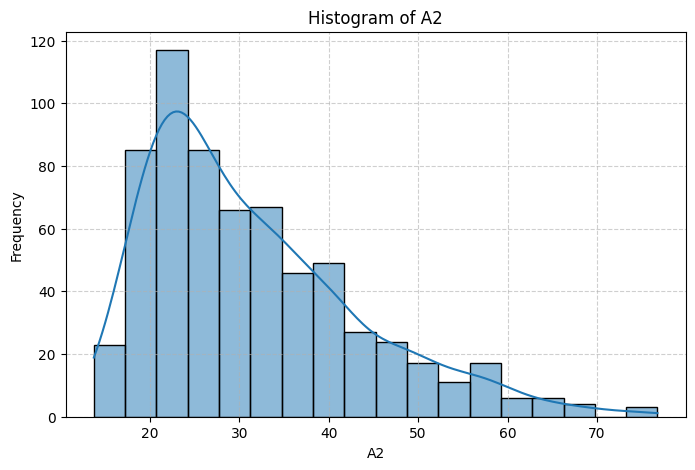

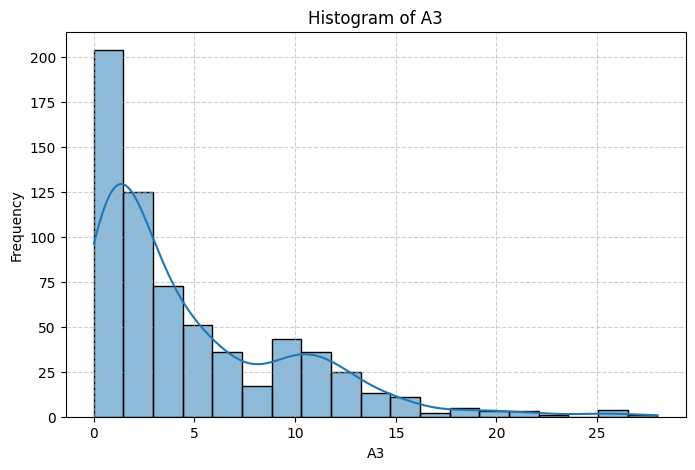

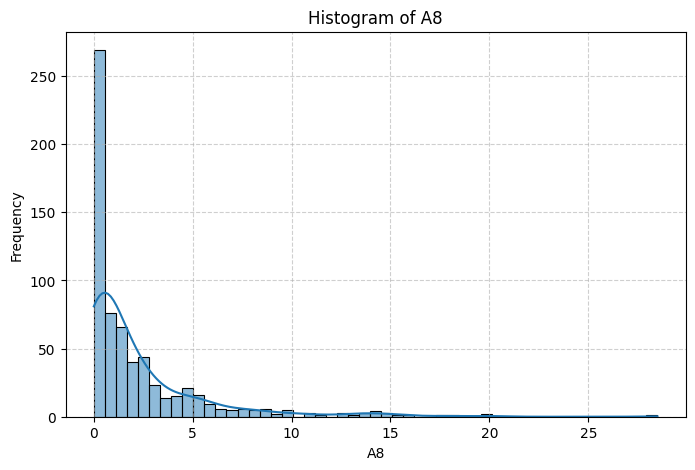

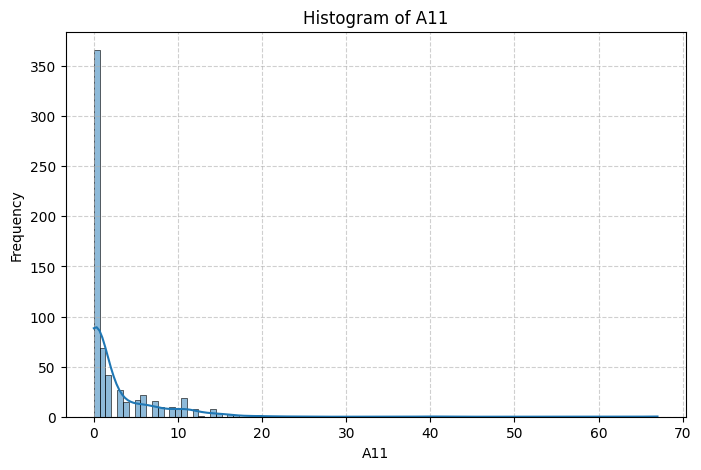

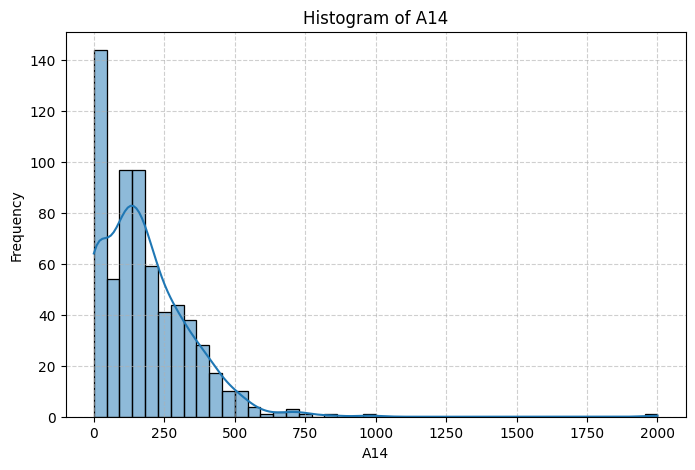

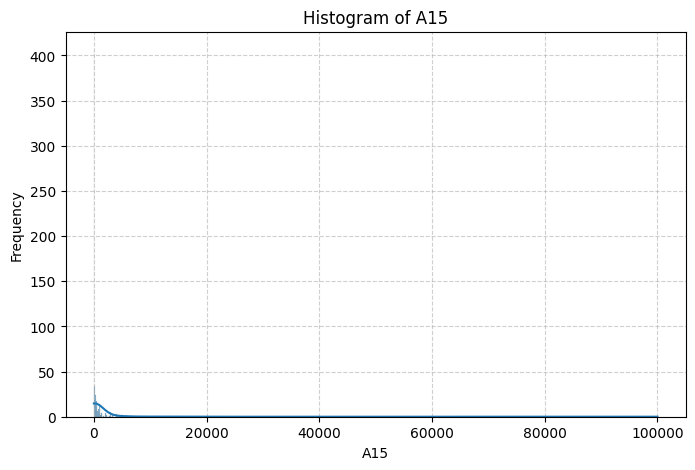

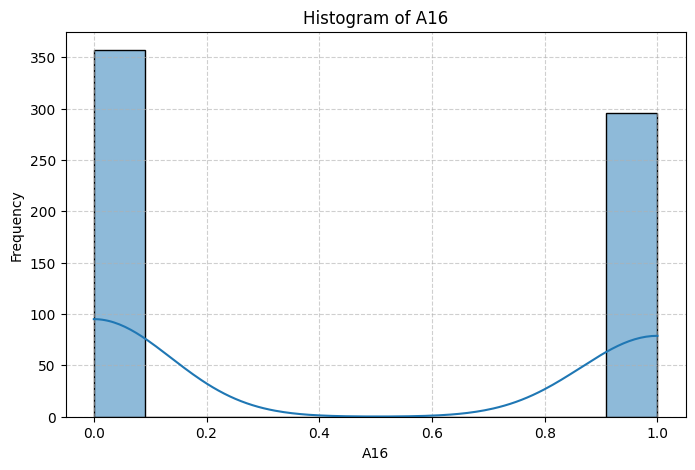


Fitting RandomizedSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best hyperparameters found:
{'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__bootstrap': True}
Best CV accuracy: 0.8714

ROC AUC (probabilities): 0.9634
Accuracy:  0.9130
Precision: 0.9455
Recall:    0.8525
F1-score:  0.8966

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        77
           1       0.95      0.85      0.90        61

    accuracy                           0.91       138
   macro avg       0.92      0.91      0.91       138
weighted avg       0.92      0.91      0.91       138



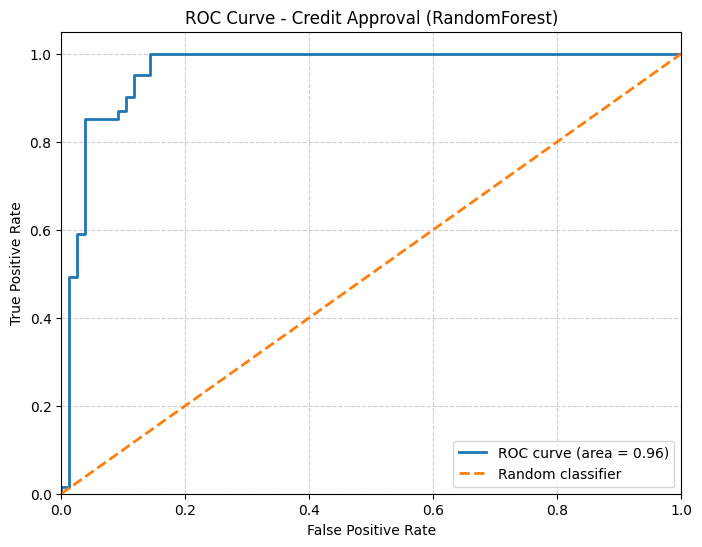

In [85]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

df = df_crx.copy()

df.columns = df.columns.str.strip()

df['A16'] = df['A16'].replace({'+': 1, '-': 0}).astype(int)

X = df.drop(columns=['A16'])
y = df['A16']

numeric_features = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
categorical_features = [col for col in X.columns if col not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numerical_df_filled = df_filled.select_dtypes(include=['number'])

correlation_matrix = numerical_df_filled.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features in df_filled')
plt.show()

numerical_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A16']

for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


rf_classifier = RandomForestClassifier(random_state=42)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_classifier)
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_distributions = {
    "model__n_estimators": [100, 200, 300, 500, 800],
    "model__max_depth": [None, 3, 5, 7, 10, 15],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__bootstrap": [True, False],
}

random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_distributions,
    n_iter=30,
    cv=kf,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\nFitting RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(random_search.best_params_)
print(f"Best CV accuracy: {random_search.best_score_:.4f}")


best_clf = random_search.best_estimator_

y_pred = best_clf.predict(X_test)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC (probabilities): {roc_auc:.4f}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Credit Approval (RandomForest)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [77]:
from sklearn.linear_model import LogisticRegression

clf_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(random_state=42, solver='liblinear'))
])

cv_scores_lr = cross_val_score(clf_lr, X, y, cv=kf, scoring="accuracy")

print("\nLogistic Regression Cross-validation accuracies:", cv_scores_lr)
print(f"Mean CV accuracy (Logistic Regression): {cv_scores_lr.mean():.4f}")
print(f"Std CV accuracy (Logistic Regression):  {cv_scores_lr.std():.4f}")


Logistic Regression Cross-validation accuracies: [0.83333333 0.86231884 0.86231884 0.89130435 0.84057971]
Mean CV accuracy (Logistic Regression): 0.8580
Std CV accuracy (Logistic Regression):  0.0203


In [78]:
from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf_lr.fit(X_train_lr, y_train_lr)

print("Logistic Regression pipeline trained successfully.")
print(f"Shape of X_train_lr: {X_train_lr.shape}")
print(f"Shape of X_test_lr: {X_test_lr.shape}")
print(f"Shape of y_train_lr: {y_train_lr.shape}")
print(f"Shape of y_test_lr: {y_test_lr.shape}")

Logistic Regression pipeline trained successfully.
Shape of X_train_lr: (552, 15)
Shape of X_test_lr: (138, 15)
Shape of y_train_lr: (552,)
Shape of y_test_lr: (138,)


ROC AUC (Logistic Regression): 0.9621
Accuracy (Logistic Regression):  0.8623
Precision (Logistic Regression): 0.8500
Recall (Logistic Regression):    0.8361
F1-score (Logistic Regression):  0.8430

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88        77
           1       0.85      0.84      0.84        61

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138



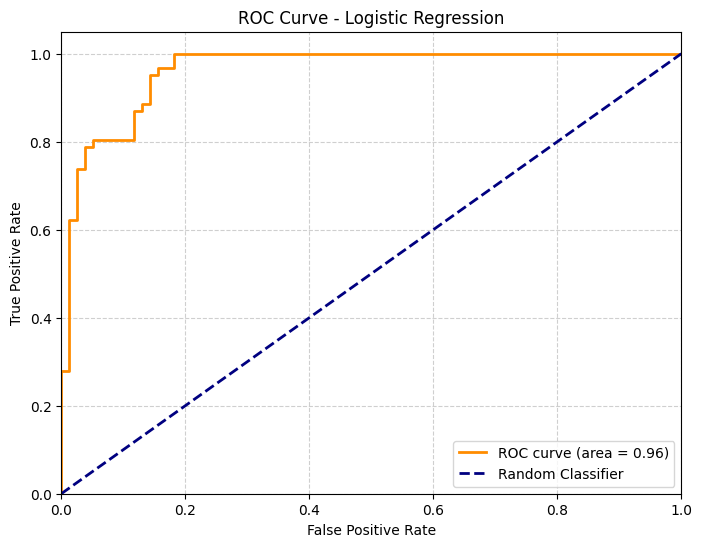

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

y_pred_lr = clf_lr.predict(X_test_lr)
y_pred_proba_lr = clf_lr.predict_proba(X_test_lr)[:, 1]

roc_auc_lr = roc_auc_score(y_test_lr, y_pred_proba_lr)
print(f"ROC AUC (Logistic Regression): {roc_auc_lr:.4f}")

accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
precision_lr = precision_score(y_test_lr, y_pred_lr)
recall_lr = recall_score(y_test_lr, y_pred_lr)
f1_lr = f1_score(y_test_lr, y_pred_lr)

print(f"Accuracy (Logistic Regression):  {accuracy_lr:.4f}")
print(f"Precision (Logistic Regression): {precision_lr:.4f}")
print(f"Recall (Logistic Regression):    {recall_lr:.4f}")
print(f"F1-score (Logistic Regression):  {f1_lr:.4f}")

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test_lr, y_pred_lr))

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()